# RISE

In [3]:
#Imports & Config

import re, os, textwrap, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

import spacy
from sentence_transformers import SentenceTransformer, util
from wordcloud import WordCloud


In [4]:
import pandas as pd

# Correct file name
DATA_PATH = "smart_score_rise_dataset.csv"

# Use a flexible encoding so you avoid UnicodeDecodeError
df = pd.read_csv(DATA_PATH, encoding='latin1')

# Basic checks
print("File loaded successfully!")
print("Shape:", df.shape)
print("\nColumn Names:\n", list(df.columns))

# Peek at the first few rows
df.head(3)

File loaded successfully!
Shape: (1000, 11)

Column Names:
 ['Encumbered Funds', 'Are you/have you worked on a research project with faculty, either as a capstone project or as course work?', 'What is the title of your research/capstone project?', 'Please provide a description or abstract of your research.', 'Term GPA (use if sem 2 of above)', 'if sem 1 use this GPA', 'Campus', 'Major', 'Semester', 'Student Type', 'Academic Standing']


,Encumbered Funds,"Are you/have you worked on a research project with faculty, either as a capstone project or as course work?",What is the title of your research/capstone project?,Please provide a description or abstract of your research.,Term GPA (use if sem 2 of above),if sem 1 use this GPA,Campus,Major,Semester,Student Type,Academic Standing
0,$903.0,Yes,The Impact of Nature-Based Recreational Therap...,This study explores the effectiveness of a nat...,97.87,49.79,Midland,Therapeutic Recreation(TREC),8,Full-time,Good Standing
1,$973.0,Yes,The Influence of Flexible Work Arrangements on...,This paper examines the relationship between t...,99.98,98.47,Barrie downtown,Human Resources Management(HRMN),6,Part-time,Good Standing
2,$3756.0,No,Integrating Passive Solar Design Principles in...,This project investigates the application of p...,89.10,99.50,Midland,Architectural Technology(ARTE),1,Part-time,Good Standing


In [5]:
cols = [c for c in df.columns]
def has_any(s, keys): return any(k.lower() in s.lower() for k in keys)

title_candidates = [c for c in cols if has_any(c, ["title"])]
abstract_candidates = [c for c in cols if has_any(c, ["description", "abstract", "project", "proposal"])]

print("Detected title candidates:", title_candidates)
print("Detected abstract candidates:", abstract_candidates)

TITLE_COL   = title_candidates[0]   if title_candidates else cols[0]
ABSTRACT_COL= abstract_candidates[0] if abstract_candidates else cols[1]

print(f"Using TITLE_COL   → {TITLE_COL}")
print(f"Using ABSTRACT_COL→ {ABSTRACT_COL}")

Detected title candidates: ['What is the title of your research/capstone project?']
Detected abstract candidates: ['Are you/have you worked on a research project with faculty, either as a capstone project or as course work?', 'What is the title of your research/capstone project?', 'Please provide a description or abstract of your research.']
Using TITLE_COL   → What is the title of your research/capstone project?
Using ABSTRACT_COL→ Are you/have you worked on a research project with faculty, either as a capstone project or as course work?


Rows: 1000

Missing values (top 20 cols):


Encumbered Funds                                                                                               0
Are you/have you worked on a research project with faculty, either as a capstone project or as course work?    0
What is the title of your research/capstone project?                                                           0
Please provide a description or abstract of your research.                                                     0
Term GPA (use if sem 2 of above)                                                                               0
if sem 1 use this GPA                                                                                          0
Campus                                                                                                         0
Major                                                                                                          0
Semester                                                                                        

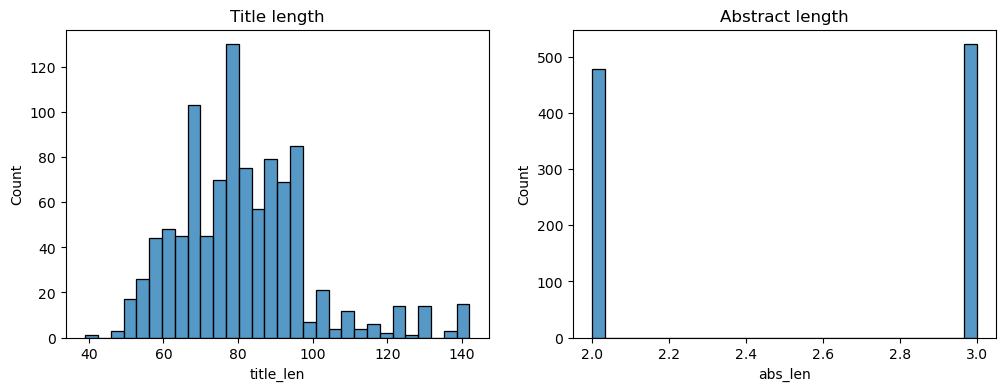

In [6]:
#EDA

print("Rows:", len(df))
print("\nMissing values (top 20 cols):")
display(df.isna().sum().sort_values(ascending=False).head(20))

# Text length distributions
df["title_len"] = df[TITLE_COL].astype(str).str.len()
df["abs_len"]   = df[ABSTRACT_COL].astype(str).str.len()

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df["title_len"], bins=30, ax=ax[0]); ax[0].set_title("Title length")
sns.histplot(df["abs_len"], bins=30, ax=ax[1]); ax[1].set_title("Abstract length")
plt.show()

In [8]:
# Wordcloud for abstracts
text_all = " ".join(df[ABSTRACT_COL].astype(str).tolist())
wc = WordCloud(width=1000, height=400, background_color="white").generate(text_all)



In [9]:
#spaCy preprocessing (tokenize, lowercase, stopwords, lemmatize)

nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat"])

def spacy_clean(text: str) -> str:
    doc = nlp(text.lower())
    kept = []
    for t in doc:
        # keep alphanumeric lemmas, drop stop/punct/spaces
        if t.is_stop or t.is_punct or t.is_space:
            continue
        lemma = t.lemma_.strip()
        if lemma and re.search(r"[a-z0-9]", lemma):
            kept.append(lemma)
    return " ".join(kept)

df["clean_text"] = (df[TITLE_COL].astype(str) + ". " + df[ABSTRACT_COL].astype(str)).apply(spacy_clean)
df[["clean_text"]].head(3)

,clean_text
0,impact nature base recreational therapy anxiet...
1,influence flexible work arrangement employee r...
2,integrate passive solar design principle low r...


In [10]:
#Rubrics

rubric = {
    "originality":  "Assess how original, creative or innovative the project idea and approach are.",
    "clarity":      "Assess clarity, organization, and logical flow of the writing and abstract structure.",
    "rigor":        "Assess depth and methodological rigor: feasibility, alignment, and detail of methods.",
    "impact":       "Assess potential real-world impact: meaningful benefit to industry, community, or society."
}


anchors = {
    "originality":  "highly original, inventive, novel concept, new methods, breakthrough innovation",
    "clarity":      "exceptionally clear, concise, well structured, organized, easy to follow",
    "rigor":        "robust methodology, detailed methods, rigorous, feasible, strong alignment to objectives",
    "impact":       "significant real-world outcomes, high value, societal benefit, measurable industry impact"
}

In [11]:
#SBERT semantic scoring → scale to 1–6


sbert = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Build prompts per rubric: instruction + anchor text
def build_prompt(crit):
    return f"{rubric[crit]} Consider: {anchors[crit]}"

prompts = {k: build_prompt(k) for k in rubric.keys()}
prompt_emb = {k: sbert.encode(v, convert_to_tensor=True, normalize_embeddings=True) for k,v in prompts.items()}

# Embed each abstract/title combined
abs_emb = sbert.encode(df["clean_text"].tolist(), convert_to_tensor=True, normalize_embeddings=True)


def to_scale_1_6(sim):
    # sim is in [-1,1] (typically ~ 0.3–0.8 for good matches)
    # map to [1,6] with MinMax-like affine transform
    return np.clip( ( (sim + 1) / 2 ) * 5 + 1 , 1, 6)

scores = {}
for crit in rubric.keys():
    sim = util.cos_sim(abs_emb, prompt_emb[crit]).cpu().numpy().ravel()
    scores[crit] = to_scale_1_6(sim)

score_df = pd.DataFrame(scores)
score_df["overall"] = score_df.mean(axis=1)
score_df.head(3)



,originality,clarity,rigor,impact,overall
0,3.817087,3.658429,3.697505,3.985291,3.789578
1,3.571792,3.619933,3.907705,3.896692,3.749030
2,3.756598,3.678012,3.610359,3.782476,3.706861


In [12]:
#Train a simple explainable baseline (TF-IDF ➜ LinearSVR) using SBERT scores as pseudo-labels

# Vectorize textual features
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=3)
X = tfidf.fit_transform(df["clean_text"])

# Train a regressor per rubric criterion to mimic SBERT scores
models = {}
metrics = []
for crit in rubric.keys():
    y = score_df[crit].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    reg = LinearSVR(random_state=42)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    models[crit] = reg
    metrics.append((crit, mae, r2))

pd.DataFrame(metrics, columns=["criterion","MAE","R2"])


,criterion,MAE,R2
0,originality,0.010904,0.960236
1,clarity,0.015331,0.898699
2,rigor,0.011341,0.942906
3,impact,0.012570,0.977461


In [13]:
# Per-applicant feedback (rows 30–40)

start, stop = 30, 40  # inclusive range you asked for
subset = df.iloc[start:stop+1].copy()

# feedback generator
def feedback_row(i):
    row = subset.iloc[i]
    base_idx = subset.index[i]
    # Use SBERT scores for feedback (best semantic quality)
    s = score_df.loc[base_idx, ["originality","clarity","rigor","impact","overall"]]

    comments = []
    def bullet(txt): return "• " + txt

    # Simple rule-based comments you can refine per threshold
    if s["originality"] >= 5:
        comments.append(bullet("Originality: Strongly innovative and fresh."))
    elif s["originality"] >= 4:
        comments.append(bullet("Originality: Noticeable creativity with new elements."))
    else:
        comments.append(bullet("Originality: Consider adding a stronger novel angle."))

    if s["clarity"] >= 5:
        comments.append(bullet("Clarity: Clear, well-structured abstract with smooth flow."))
    elif s["clarity"] >= 4:
        comments.append(bullet("Clarity: Generally organized; tighten a few sentences."))
    else:
        comments.append(bullet("Clarity: Rework structure and objectives for readability."))

    if s["rigor"] >= 5:
        comments.append(bullet("Rigor: Well-developed, feasible methodology."))
    elif s["rigor"] >= 4:
        comments.append(bullet("Rigor: Sound approach; add more methodological detail."))
    else:
        comments.append(bullet("Rigor: Methods vague—add design, sampling, or evaluation detail."))

    if s["impact"] >= 5:
        comments.append(bullet("Impact: Strong potential for meaningful real-world benefit."))
    elif s["impact"] >= 4:
        comments.append(bullet("Impact: Relevant problem; clarify expected outcomes/benefits."))
    else:
        comments.append(bullet("Impact: Clarify the stakeholder value and measurable outcomes."))

    wrap = lambda t: textwrap.fill(t, 120)
    return pd.Series({
        "row_id": int(base_idx),
        "title": row[TITLE_COL],
        "originality": round(float(s["originality"]),2),
        "clarity": round(float(s["clarity"]),2),
        "rigor": round(float(s["rigor"]),2),
        "impact": round(float(s["impact"]),2),
        "overall": round(float(s["overall"]),2),
        "feedback": wrap("\n".join(comments))
    })

feedback_tbl = pd.concat([feedback_row(i) for i in range(len(subset))], axis=1).T
feedback_tbl.sort_values("overall", ascending=False).reset_index(drop=True)


,row_id,title,originality,clarity,rigor,impact,overall,feedback
0,35,A Customer Experience Audit of a Boutique Hote...,4.02,3.83,4.04,4.14,4.01,• Originality: Noticeable creativity with new ...
1,37,An Analysis of the Theme of Identity in Modern...,4.05,4.04,3.84,3.91,3.96,• Originality: Noticeable creativity with new ...
2,36,A Market Entry Strategy for a New Organic Food...,4.01,3.58,3.84,4.07,3.87,• Originality: Noticeable creativity with new ...
3,39,A Destination Marketing Plan for a Small Town ...,4.1,3.62,3.71,4.05,3.87,• Originality: Noticeable creativity with new ...
4,33,A Comparative Study of Modern Philosophical Th...,3.95,3.91,3.85,3.69,3.85,• Originality: Consider adding a stronger nove...
5,34,The Impact of a Forest Bathing Program on the ...,3.64,3.74,3.85,3.99,3.81,• Originality: Consider adding a stronger nove...
6,30,A Privacy Impact Assessment of a Digital Patie...,3.62,3.59,3.7,4.12,3.76,• Originality: Consider adding a stronger nove...
7,31,Threat Modeling for a Smart Home Network: A Ca...,3.77,3.38,3.73,3.88,3.69,• Originality: Consider adding a stronger nove...
8,32,Developing a Point-of-Care Diagnostic Test for...,3.67,3.63,3.82,3.65,3.69,• Originality: Consider adding a stronger nove...
9,38,The Design and Testing of an Automated Power F...,3.67,3.4,3.76,3.6,3.61,• Originality: Consider adding a stronger nove...


In [14]:
feedback_tbl.to_csv("smart_score_rise_dataset_clean.csv", index=False, encoding="utf-8")
print("Clean file saved as smart_score_rise_dataset_clean.csv")

✅ Clean file saved as smart_score_rise_dataset_clean.csv


In [15]:
#table view + save CSV

cols_out = ["row_id","title","originality","clarity","rigor","impact","overall","feedback"]
out = feedback_tbl[cols_out].copy().sort_values("overall", ascending=False)
display(out.style.format(precision=2).background_gradient(subset=["overall"], cmap="YlGn"))

SAVE_PATH = "rise_feedback_rows_30_40.csv"
out.to_csv(SAVE_PATH, index=False, encoding="utf-8")
print("Saved:", SAVE_PATH)


,row_id,title,originality,clarity,rigor,impact,overall,feedback
5,35,A Customer Experience Audit of a Boutique Hotel: Analyzing Guest Journey Mapping and Feedback,4.02,3.83,4.04,4.14,4.01,• Originality: Noticeable creativity with new elements. • Clarity: Rework structure and objectives for readability. • Rigor: Sound approach; add more methodological detail. • Impact: Relevant problem; clarify expected outcomes/benefits.
7,37,An Analysis of the Theme of Identity in Modern Canadian Literature,4.05,4.04,3.84,3.91,3.96,"• Originality: Noticeable creativity with new elements. • Clarity: Generally organized; tighten a few sentences. • Rigor: Methods vague—add design, sampling, or evaluation detail. • Impact: Clarify the stakeholder value and measurable outcomes."
6,36,A Market Entry Strategy for a New Organic Food Product in Canada,4.01,3.58,3.84,4.07,3.87,"• Originality: Noticeable creativity with new elements. • Clarity: Rework structure and objectives for readability. • Rigor: Methods vague—add design, sampling, or evaluation detail. • Impact: Relevant problem; clarify expected outcomes/benefits."
9,39,A Destination Marketing Plan for a Small Town Based on its Historical Heritage,4.10,3.62,3.71,4.05,3.87,"• Originality: Noticeable creativity with new elements. • Clarity: Rework structure and objectives for readability. • Rigor: Methods vague—add design, sampling, or evaluation detail. • Impact: Relevant problem; clarify expected outcomes/benefits."
3,33,A Comparative Study of Modern Philosophical Thought,3.95,3.91,3.85,3.69,3.85,"• Originality: Consider adding a stronger novel angle. • Clarity: Rework structure and objectives for readability. • Rigor: Methods vague—add design, sampling, or evaluation detail. • Impact: Clarify the stakeholder value and measurable outcomes."
4,34,The Impact of a Forest Bathing Program on the Stress Levels of University Students,3.64,3.74,3.85,3.99,3.81,"• Originality: Consider adding a stronger novel angle. • Clarity: Rework structure and objectives for readability. • Rigor: Methods vague—add design, sampling, or evaluation detail. • Impact: Clarify the stakeholder value and measurable outcomes."
0,30,A Privacy Impact Assessment of a Digital Patient Intake System,3.62,3.59,3.70,4.12,3.76,"• Originality: Consider adding a stronger novel angle. • Clarity: Rework structure and objectives for readability. • Rigor: Methods vague—add design, sampling, or evaluation detail. • Impact: Relevant problem; clarify expected outcomes/benefits."
1,31,Threat Modeling for a Smart Home Network: A Case Study,3.77,3.38,3.73,3.88,3.69,"• Originality: Consider adding a stronger novel angle. • Clarity: Rework structure and objectives for readability. • Rigor: Methods vague—add design, sampling, or evaluation detail. • Impact: Clarify the stakeholder value and measurable outcomes."
2,32,Developing a Point-of-Care Diagnostic Test for Early Detection of Dengue Fever,3.67,3.63,3.82,3.65,3.69,"• Originality: Consider adding a stronger novel angle. • Clarity: Rework structure and objectives for readability. • Rigor: Methods vague—add design, sampling, or evaluation detail. • Impact: Clarify the stakeholder value and measurable outcomes."
8,38,The Design and Testing of an Automated Power Factor Correction System,3.67,3.40,3.76,3.60,3.61,"• Originality: Consider adding a stronger novel angle. • Clarity: Rework structure and objectives for readability. • Rigor: Methods vague—add design, sampling, or evaluation detail. • Impact: Clarify the stakeholder value and measurable outcomes."


Saved: rise_feedback_rows_30_40.csv


In [16]:
#Quick explanations for one row (why the TF-IDF baseline predicted that)

def top_features_for(crit, text, k=15):
    vec = tfidf.transform([text])
    reg = models[crit]
    coefs = reg.coef_.ravel()
    idxs = vec.nonzero()[1]
    weights = coefs[idxs] * vec.toarray()[0, idxs]
    feats = np.array(tfidf.get_feature_names_out())[idxs]
    order = np.argsort(-np.abs(weights))[:k]
    return pd.DataFrame({"feature": feats[order], "weight": weights[order]})

row_to_explain = 33  # pick any ID in 30..40
text_raw = df.loc[row_to_explain, TITLE_COL] + ". " + df.loc[row_to_explain, ABSTRACT_COL]
text_clean = df.loc[row_to_explain, "clean_text"]

for crit in ["originality","clarity","rigor","impact"]:
    print(f"\nTop TF-IDF features influencing '{crit}' (baseline student model) for row {row_to_explain}:")
    display(top_features_for(crit, text_clean, k=12))


Top TF-IDF features influencing 'originality' (baseline student model) for row 33:


,feature,weight
0,comparative study,0.115612
1,study,0.084104
2,modern,0.036209
3,yes,-0.005221
4,comparative,0.004849



Top TF-IDF features influencing 'clarity' (baseline student model) for row 33:


,feature,weight
0,modern,0.203718
1,comparative study,0.071114
2,comparative,0.051741
3,yes,-0.040134
4,study,0.016829



Top TF-IDF features influencing 'rigor' (baseline student model) for row 33:


,feature,weight
0,comparative study,0.084947
1,study,0.044762
2,comparative,0.028050
3,modern,-0.026092
4,yes,-0.008655



Top TF-IDF features influencing 'impact' (baseline student model) for row 33:


,feature,weight
0,modern,-0.162437
1,yes,0.056346
2,comparative,-0.034368
3,study,0.023004
4,comparative study,0.016032
